## Capstone Part 2
Data Collection

Target Reddit subreddits

https://www.reddit.com/r/london/
https://www.reddit.com/r/Liverpool/
https://www.reddit.com/r/Leeds/
https://www.reddit.com/r/sheffield/
https://www.reddit.com/r/manchester/
https://www.reddit.com/r/glasgow/
https://www.reddit.com/r/Edinburgh/
https://www.reddit.com/r/Belfast/
https://www.reddit.com/r/Cardiff/

Reddit API Documentation
https://github.com/reddit-archive/reddit/wiki/API

PRAW, Reddit API Wrapper
https://praw.readthedocs.io/en/latest/getting_started/quick_start.html

Pushshift.io, get historical Reddit submissions IDs
https://pushshift.io/

Most of the code is taken from tutorial
https://medium.com/@pasdan/how-to-scrap-reddit-using-pushshift-io-via-python-a3ebcc9b83f4

First step was to register for a Reddit Developer Account,
this allowed me to get client id for my code

#### First attempt at using Reddit API directly, I could only go back a limited number of submission before running into a buffer issue.

In [1]:
import pandas as pd
import urllib.request as ur
import json
import time

In [5]:
#Header to be submitted to reddit.
hdr = {'User-Agent': 'redditAPI:v1.0'}

#Link to the subreddit of interest.
url = "https://www.reddit.com/r/London/.json?sort=top&t;=all"

#Makes a request object and receive a response.
req = ur.Request(url, headers=hdr)
response = ur.urlopen(req).read()

#Loads the json data into python.
json_data = json.loads(response.decode('utf-8'))

#The actual data starts.
data = json_data['data']['children']

for i in range(5):
    #reddit only accepts one request every 2 seconds, adds a delay between each loop
    time.sleep(2)
    last = data[-1]['data']['name']
    url = 'https://www.reddit.com/r/London/.json?sort=top&t;=all&limit;=100&after;=%s' % last
    req = ur.Request(url, headers=hdr)
    text_data = ur.urlopen(req).read()
    datatemp = json.loads(text_data.decode('utf-8'))
    data += datatemp['data']['children']
    print(str(len(data))+" posts loaded")


54 posts loaded
81 posts loaded
108 posts loaded
135 posts loaded
162 posts loaded


In [8]:
data_names = [value for value in data[0]['data']]

#Create a list of dictionaries to be loaded into a pandas dataframe
df_loadinglist = []
for i in range(0, len(data)):
    dictionary = {}
    for names in data_names:
        try:
            dictionary[str(names)] = data[i]['data'][str(names)]
        except:
            dictionary[str(names)] = 'None'
    df_loadinglist.append(dictionary)
df=pd.DataFrame(df_loadinglist)
df.head(3)

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,None,london,**PLEASE NOTE**: we are still in the midst of ...,t2_6l4z3,False,None,0,False,Megathread for visitors and new &amp; existing...,[],...,None,/r/london/comments/mp19vi/megathread_for_visit...,all_ads,True,https://www.reddit.com/r/london/comments/mp19v...,391788,1.618181e+09,0,None,False
1,None,london,Causes for optimism this week:\n\n- **Cases** ...,t2_8fr47,False,None,0,False,LESS THAN 24 HOURS TO BEER (the weekly coronav...,[],...,dark,/r/london/comments/moq1ka/less_than_24_hours_t...,all_ads,True,https://www.reddit.com/r/london/comments/moq1k...,391788,1.618143e+09,0,None,False
2,None,london,,t2_zmaow,False,None,0,False,Last night’s “Infinity Sunset”,[],...,None,/r/london/comments/mtb0t5/last_nights_infinity...,all_ads,False,https://i.redd.it/09u3a38l2xt61.jpg,391788,1.618745e+09,0,None,False


I found a tutorial online for pulling historical reddit submissions from pushshift.io

In [9]:
import math
import json
import requests
import itertools
import numpy as np
import time
from datetime import datetime, timedelta

from IPython.display import clear_output

In [10]:
def make_request(uri, max_retries = 5):
    def fire_away(uri):
        response = requests.get(uri)
        assert response.status_code == 200
        return json.loads(response.content)
    current_tries = 1
    while current_tries < max_retries:
        try:
            time.sleep(1)
            response = fire_away(uri)
            return response
        except:
            time.sleep(1)
            current_tries += 1
            return fire_away(uri)

In [11]:
def pull_posts_for(subreddit, start_at, end_at):
    
   
    SIZE = 100
    URI_TEMPLATE = r'https://api.pushshift.io/reddit/search/submission?subreddit={}&after={}&before={}&size={}'
    
    post_collections = map_posts( 
        make_request( 
            URI_TEMPLATE.format( 
                subreddit, start_at, end_at, SIZE))['data'])
    n = len(post_collections)
    while n == SIZE:
        last = post_collections[-1]
        new_start_at = last['created_utc'] - (10)
        
        more_posts = map_posts( 
            make_request( 
                URI_TEMPLATE.format( 
                    subreddit, new_start_at, end_at, SIZE))['data'])
        
        n = len(more_posts)
        post_collections.extend(more_posts)
    clear_output(wait=True)
    print(pd.Timestamp(start_at, unit='s'),' - ',len(post_collections))
    return post_collections

In [19]:
#set the range for our scrape, getting 2 splits each day
index = pd.date_range(start='31/12/2019', end='1/1/2021', freq='1D')

#convert to Unix time which is used by the Reddit API
epoc_index = (index - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

#Final intaval will be pairs of over lapping start and stop time stamps
intervals = []
for i in range(0,len(epoc_index)-1):
    intervals.append([(epoc_index[i]-30),(epoc_index[i+1]+30)])

In [17]:
json_items_clean = ['wls',  'domain', 'id',
 'is_reddit_media_domain',  
 'is_self', 'is_video', 'likes',  'link_flair_css_class',
 'link_flair_text', 'link_flair_text_color',  'whitelist_status', 
 'created_utc', 'created', 'contest_mode', 'allow_live_comments', 
   'author',  'author_flair_css_class',
   'author_flair_text',  'author_fullname', 'score',
  'selftext', 'selftext_html', 'send_replies', 
  'subreddit', 'subreddit_id', 'subreddit_name_prefixed', 'subreddit_subscribers',
 'subreddit_type', 'suggested_sort', 'thumbnail', 'thumbnail_height', 'thumbnail_width', 'title',
 'top_awarded_type', 'total_awards_received',  'ups', 'upvote_ratio',
 'parent_whitelist_status', 
  'name', 'no_follow', 'num_comments', 'num_crossposts', 'num_reports', 'over_18', 'url',
 'permalink']

In [26]:
def map_posts(posts):
    df = []

    # loop through each post pulled from res and append to df
    for post in posts:
        post_data = {}
        for x in json_items_clean:
            try:
                post_data[x] = post[x]
            except:
                post_data[x] = ''
#         post_data['kind'] = post['kind']
        post_data['date_clean'] =  datetime.fromtimestamp(post['created_utc']).strftime('%Y-%m-%dT%H:%M:%SZ')
        df.append(post_data)

    return df

In [20]:
subreddit = 'Cardiff'
posts = []
for interval in intervals:
    pulled_posts = pull_posts_for(
        subreddit, interval[0], interval[1])
    
    posts.extend(pulled_posts)
    time.sleep(.500)
## ~ 4306
print(len(posts))

2020-12-09 23:59:30  -  61
1534


In [21]:
def plot_day_count(dates):
    pl = pd.DataFrame(index=pd.to_datetime(dates))
    pl['Count']=1
    pl.resample('D').sum().plot();

In [27]:
df_city = pd.DataFrame()
df_city = df_city.append(pd.DataFrame(map_posts(posts)))
file_string = f'./second_pass_{subreddit}.csv'
df_city.to_csv(file_string)

In [28]:
df_city.head(3)

,wls,domain,id,is_reddit_media_domain,is_self,is_video,likes,link_flair_css_class,link_flair_text,link_flair_text_color,...,parent_whitelist_status,name,no_follow,num_comments,num_crossposts,num_reports,over_18,url,permalink,date_clean
0,,,ehzko4,,,,,,,,...,,,,,,,,,,2019-12-31T07:15:07Z
1,,,ei0vv8,,,,,,,,...,,,,,,,,,,2019-12-31T09:51:01Z
2,,,ei0vv9,,,,,,,,...,,,,,,,,,,2019-12-31T09:51:01Z


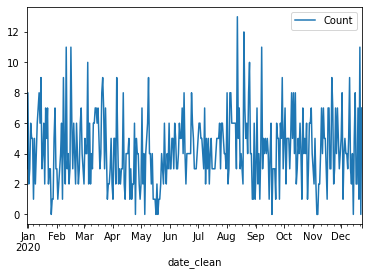

In [29]:
plot_day_count(df_city['date_clean'])

Once you have the submission IDs for all posts in 2020, we can use the PRAW reddit wrapper to individually call each port with more than 0 posts and pull the post details and comments.

In [30]:
import praw

In [31]:
reddit = praw.Reddit(
    client_id="<Client Id>",
    client_secret="<Secret>",
    password="<PASSWORD>",
    user_agent="testscript by <Username>",
    username="<USER_NAME>",
)

In [32]:
print(reddit.user.me())

Jacobi79


In [38]:
def get_submission_reddit(submission_item):
    submission_dict = {
        'comment_limit':submission_item.comment_limit,
        'comment_sort':submission_item.comment_sort,
        'id':submission_item.id,
        'approved_at_utc':submission_item.approved_at_utc,
        'selftext':submission_item.selftext,
        'saved':submission_item.saved,
        'mod_reason_title':submission_item.mod_reason_title,
        'gilded':submission_item.gilded,
        'clicked':submission_item.clicked,
        'title':submission_item.title,
        'link_flair_richtext':submission_item.link_flair_richtext,
        'subreddit_name_prefixed':submission_item.subreddit_name_prefixed,
        'hidden':submission_item.hidden,
        'pwls':submission_item.pwls,
        'link_flair_css_class':submission_item.link_flair_css_class,
        'downs':submission_item.downs,
        'thumbnail_height':submission_item.thumbnail_height,
        'top_awarded_type':submission_item.top_awarded_type,
        'parent_whitelist_status':submission_item.parent_whitelist_status,
        'hide_score':submission_item.hide_score,
        'name':submission_item.name,
        'quarantine':submission_item.quarantine,
        'link_flair_text_color':submission_item.link_flair_text_color,
        'upvote_ratio':submission_item.upvote_ratio,
        'author_flair_background_color':submission_item.author_flair_background_color,
        'subreddit_type':submission_item.subreddit_type,
        'ups':submission_item.ups,
        'total_awards_received':submission_item.total_awards_received,
        'thumbnail_width':submission_item.thumbnail_width,
        'author_flair_template_id':submission_item.author_flair_template_id,
        'is_original_content':submission_item.is_original_content,
        'secure_media':submission_item.secure_media,
        'is_reddit_media_domain':submission_item.is_reddit_media_domain,
        'is_meta':submission_item.is_meta,
        'category':submission_item.category,
        'link_flair_text':submission_item.link_flair_text,
        'can_mod_post':submission_item.can_mod_post,
        'score':submission_item.score,
        'approved_by':submission_item.approved_by,
        'thumbnail':submission_item.thumbnail,
        'edited':submission_item.edited,
        'author_flair_css_class':submission_item.author_flair_css_class,
        'content_categories':submission_item.content_categories,
        'is_self':submission_item.is_self,
        'mod_note':submission_item.mod_note,
        'created':submission_item.created,
        'link_flair_type':submission_item.link_flair_type,
        'wls':submission_item.wls,
        'removed_by_category':submission_item.removed_by_category,
        'banned_by':submission_item.banned_by,
        'domain':submission_item.domain,
        'allow_live_comments':submission_item.allow_live_comments,
        'selftext_html':submission_item.selftext_html,
        'likes':submission_item.likes,
        'suggested_sort':submission_item.suggested_sort,
        'banned_at_utc':submission_item.banned_at_utc,
        'view_count':submission_item.view_count,
        'archived':submission_item.archived,
        'no_follow':submission_item.no_follow,
        'is_crosspostable':submission_item.is_crosspostable,
        'pinned':submission_item.pinned,
        'over_18':submission_item.over_18,
        'media_only':submission_item.media_only,
        'can_gild':submission_item.can_gild,
        'spoiler':submission_item.spoiler,
        'locked':submission_item.locked,
        'author_flair_text':submission_item.author_flair_text,
        'visited':submission_item.visited,
        'removed_by':submission_item.removed_by,
        'num_reports':submission_item.num_reports,
        'distinguished':submission_item.distinguished,
        'subreddit_id':submission_item.subreddit_id,
        'mod_reason_by':submission_item.mod_reason_by,
        'removal_reason':submission_item.removal_reason,
        'link_flair_background_color':submission_item.link_flair_background_color,
        'is_robot_indexable':submission_item.is_robot_indexable,
        'num_duplicates':submission_item.num_duplicates,
        'report_reasons':submission_item.report_reasons,
        'author':submission_item.author,
        'discussion_type':submission_item.discussion_type,
        'num_comments':submission_item.num_comments,
        'send_replies':submission_item.send_replies,
        'media':submission_item.media,
        'contest_mode':submission_item.contest_mode,
        'author_flair_text_color':submission_item.author_flair_text_color,
        'permalink':submission_item.permalink,
        'whitelist_status':submission_item.whitelist_status,
        'stickied':submission_item.stickied,
        'url':submission_item.url,
        'subreddit_subscribers':submission_item.subreddit_subscribers,
        'created_utc':submission_item.created_utc,
        'num_crossposts':submission_item.num_crossposts,
        'is_video':submission_item.is_video        
    }
    return submission_dict

In [39]:
def get_comments_reddit(comment_item):
    comment_dict = {
        'total_awards_received':comment_item.total_awards_received,
        'approved_at_utc':comment_item.approved_at_utc,
        'comment_type':comment_item.comment_type,
        'mod_reason_by':comment_item.mod_reason_by,
        'banned_by':comment_item.banned_by,
        'ups':comment_item.ups,
        'removal_reason':comment_item.removal_reason,
        'link_id':comment_item.link_id,
        'author_flair_template_id':comment_item.author_flair_template_id,
        'likes':comment_item.likes,
        'saved':comment_item.saved,
        'id':comment_item.id,
        'banned_at_utc':comment_item.banned_at_utc,
        'mod_reason_title':comment_item.mod_reason_title,
        'gilded':comment_item.gilded,
        'archived':comment_item.archived,
        'no_follow':comment_item.no_follow,
        'author':comment_item.author,
        'can_mod_post':comment_item.can_mod_post,
        'send_replies':comment_item.send_replies,
        'parent_id':comment_item.parent_id,
        'score':comment_item.score,
        'approved_by':comment_item.approved_by,
        'report_reasons':comment_item.report_reasons,
        'subreddit_id':comment_item.subreddit_id,
        'body':comment_item.body,
        'edited':comment_item.edited,
        'downs':comment_item.downs,
        'author_flair_css_class':comment_item.author_flair_css_class,
        'collapsed':comment_item.collapsed,
        'is_submitter':comment_item.is_submitter,
        'body_html':comment_item.body_html,
        'collapsed_reason':comment_item.collapsed_reason,
        'associated_award':comment_item.associated_award,
        'stickied':comment_item.stickied,
        'subreddit_type':comment_item.subreddit_type,
        'can_gild':comment_item.can_gild,
        'top_awarded_type':comment_item.top_awarded_type,
        'author_flair_text_color':comment_item.author_flair_text_color,
        'score_hidden':comment_item.score_hidden,
        'permalink':comment_item.permalink,
        'num_reports':comment_item.num_reports,
        'locked':comment_item.locked,
        'name':comment_item.name,
        'created':comment_item.created,
        'author_flair_text':comment_item.author_flair_text,
        'created_utc':comment_item.created_utc,
        'subreddit_name_prefixed':comment_item.subreddit_name_prefixed,
        'controversiality':comment_item.controversiality,
        'depth':comment_item.depth,
        'author_flair_background_color':comment_item.author_flair_background_color,
        'collapsed_because_crowd_control':comment_item.collapsed_because_crowd_control,
        'mod_note':comment_item.mod_note,
        'distinguished':comment_item.distinguished
        }
    return comment_dict

In [33]:
city = 'Belfast'
file_string = f'./first_pass_{city}.csv'
city_list = pd.read_csv(file_string)
print(len(np.unique(city_list.id[city_list.num_comments > 0])))

971


In [40]:
TIMEOUT_AFTER_COMMENT_IN_SECS = .350
subreddit_id_list = np.unique(city_list.id[city_list.num_comments > 0])
count = 0
posts_from_reddit = []
comments_from_reddit = []
for submission_id in subreddit_id_list:
    submission = reddit.submission(id=submission_id)
    posts_from_reddit.append(submission)
    submission.comments.replace_more(limit=None)
    clear_output(wait=True)
    print(count,' - ',len(subreddit_id_list))
    count = count + 1
    for comment in submission.comments.list():
        comments_from_reddit.append(comment)
        
        if TIMEOUT_AFTER_COMMENT_IN_SECS > 0:
            time.sleep(TIMEOUT_AFTER_COMMENT_IN_SECS)
    if count%500 == 0:
        comment_df = pd.DataFrame()
        for top_level_comment in comments_from_reddit:
            comment_df = comment_df.append(get_comments_reddit(top_level_comment),ignore_index=True)
        file_string = f'./comments_third_pass_{city}_{count}.csv'
        comment_df.to_csv(file_string)
        df_submissions = pd.DataFrame()
        for top_level_submission in posts_from_reddit:
            df_submissions = df_submissions.append(get_submission_reddit(top_level_submission),ignore_index=True)
        file_string = f'./submissions_third_pass_{city}_{count}.csv'
        df_submissions.to_csv(file_string)
        posts_from_reddit = []
        comments_from_reddit = []
## ~ 4306
print(len(posts_from_reddit))
## ~ 35216
print(len(comments_from_reddit))
comment_df = pd.DataFrame()
for top_level_comment in comments_from_reddit:
    comment_df = comment_df.append(get_comments_reddit(top_level_comment),ignore_index=True)
file_string = f'./comments_third_pass_{city}.csv'
comment_df.to_csv(file_string)
df_submissions = pd.DataFrame()
for top_level_submission in posts_from_reddit:
    df_submissions = df_submissions.append(get_submission_reddit(top_level_submission),ignore_index=True)
file_string = f'./submissions_third_pass_{city}.csv'
df_submissions.to_csv(file_string)
print('DONE')

5  -  6
6
383
DONE


After running the above script in batches, we now have all our data stored in multiple csv files.

In [ ]:
Data Dictonary

 'Unnamed: 0',						Index copied over from original Dataframe
 'approved_at_utc',					All Null
 'approved_by',						All Null
 'archived',							All 1
 'associated_award',					All Null
 'author',							10634 of unique authors
 'author_flair_background_color',		All Null
 'author_flair_css_class',				20 % not NaN, can be used to sort author by subclass
 'author_flair_template_id',				Nonsense IDs 
 'author_flair_text',					Can only be paired with 398 authores
 'author_flair_text_color',				Users pick dark colour text 
 'banned_at_utc',					All Null
 'banned_by',						All Null
 'body',							Target Text
 'body_html',						Target Text in Html Format
 'can_gild',							Might be a way to filter by Bot
 'can_mod_post',					All 0
 'collapsed',						5% is 1, might be related to depth
 'collapsed_because_crowd_control',		All Null
 'collapsed_reason',					Not sure
 'comment_type',					All Null
 'controversiality',					4% is 1, not sure how its calculated
 'created',							Unique timeStamp
 'created_utc',						Unique timeStamp
 'depth',							how many sub replies 
 'distinguished',						Filter for Moderator (1%)
 'downs',							All 0
 'edited',							Timestamp if post was edited
 'gilded',							Gold given (very low rate, 21 in 58,000)
 'id',								Unique ID of comment
 'is_submitter',						flag person who submitted original post(9%)
 'likes',							All Null
 'link_id',							Not 100% sure yet
 'locked',							Very low rate, 2 in 58,000
 'mod_note',						All Null
 'mod_reason_by',					All Null
 'mod_reason_title',					All Null
 'name',							Unique name of comment, related to ID
 'no_follow',						Not 100% sure, 40% is 1
 'num_reports',						All Null
 'parent_id',						ID of parent submission
 'permalink',						link to web post
 'removal_reason',					All Null
 'report_reasons',					All Null
 'saved',							All 0
 'score',							Score given to comment
 'score_hidden',						Very low rate, 262 in 58,000 (might be used to filter bot or sub reddit announcements)
 'send_replies',						Very low rate, 300 in 58,000
 'stickied',							Very low rate, 262 in 58,000
 'subreddit_id',						Link to subreddit ID
 'subreddit_name_prefixed',			subreddit name
 'subreddit_type',					subreddit type (public)
 'top_awarded_type',					All Null
 'total_awards_received',				Very Low rate, 81 in 58,000
 'ups'								Up score of the comment
    





Submissions

'Unnamed: 0',					Index copied over from original Dataframe	
 'allow_live_comments',			May filter for bots 
 'approved_at_utc',				All Null
 'approved_by',				All Null
 'archived',					All 1
 'author',					Author of the submission
 'author_flair_background_color',	All Null
 'author_flair_css_class',		linked to Author account details
 'author_flair_template_id',		Nonsense
 'author_flair_text',			linked to Author account details
 'author_flair_text_color',		linked to Author account details
 'banned_at_utc',				All Null
 'banned_by',					All Null
 'can_gild',					Maybe Filter bots (30%)
 'can_mod_post',				All 0
 'category',					All Null
 'clicked',					All 0
 'comment_limit',				all 2048
 'comment_sort',				All confidence
 'content_categories',			All Null
 'contest_mode',				All 0
 'created',					Created timestamp
 'created_utc',				Created timestamp
 'discussion_type',				All Null
 'distinguished',				Filter for Moderator
 'domain',					Link to external sites
 'downs',						All 0
 'edited',					Timestamp of edited
 'gilded',					Gold given (very low rate, 20 in 3800)
 'hidden',					All 0
 'hide_score',					All 0
 'id',						Unique Submission ID
 'is_crosspostable',			Can be posted on other subreddits
 'is_meta',					All 0
 'is_original_content',			All 0
 'is_reddit_media_domain',		Link to reddit sites
 'is_robot_indexable',			Not sure
 'is_self',					Not sure
 'is_video',					Link to video
 'likes',						All Null
 'link_flair_background_color',	All Null
 'link_flair_css_class',			can be subclassed
 'link_flair_richtext',			All Blank
 'link_flair_text',				can be subclassed
 'link_flair_text_color',		All Dark
 'link_flair_type',				All text
 'locked',					Very Rare 0.2%
 'media',						embedded links
 'media_only',					All 0
 'mod_note',					All Null
 'mod_reason_by',				All Null
 'mod_reason_title',			All Null
 'name',						Unique ID
 'no_follow',					No idea
 'num_comments',				number of posts in each submission
 'num_crossposts',				cross post from another subreddit
 'num_duplicates',				Not 100% sure
 'num_reports',				All Null
 'over_18',					Is this NSFW related
 'parent_whitelist_status',		All all_ads
 'permalink',					Link to web source
 'pinned',					All 0
 'pwls',						All 6
 'quarantine',					All 0
 'removal_reason',				All Null
 'removed_by',					All Null
 'removed_by_category',			Flag for removed submissions
 'report_reasons',				All Null
 'saved',						All 0
 'score',						Score of the submission
 'secure_media',				add embedded links
 'selftext',					Text of submission
 'selftext_html',				Text of submission in HTML
 'send_replies',				Very rare (160 in 3800)
 'spoiler',					Very rare (2 in 3800)
 'stickied',					All 0
 'subreddit_id',				Subreddit ID
 'subreddit_name_prefixed',		Subreddit Details
 'subreddit_subscribers',		Subreddit Details
 'subreddit_type',				Subreddit Details
 'suggested_sort',				Very rare (68 in 3800)
 'thumbnail',					web link to thumbnail image
 'thumbnail_height',			Meta data on thumbnail		
 'thumbnail_width',				Meta data on thumbnail
 'title',						Title of Subreddit
 'top_awarded_type',			All Null
 'total_awards_received',		Very rare (45 in 3800)	
 'ups',						score of submission
 'upvote_ratio',				score of submission
 'url',						web link to target submission
 'view_count',					All Null
 'visited',					All 0
 'whitelist_status',			related to NSFW
 'wls'						related to NSFW


In [41]:
comment_col = [

# Unique comment details
'id',
'name',
'ups',
'score',
'parent_id',
'depth',

# Main target 
'body',
'body_html',
'permalink',

# Author details
'author', 
'author_flair_css_class',
'author_flair_text',
'author_flair_text_color',
'is_submitter',

# Date 
'created',
'created_utc',
'edited',

# Parent Subreddit
'subreddit_id',
'subreddit_name_prefixed',
'subreddit_type',

# Monor attributes, may flag bots or moderators
'total_awards_received',
'can_gild',
'collapsed_reason',
'controversiality',
'distinguished',
'gilded',
'link_id',
'locked',
'no_follow',
'score_hidden',
'send_replies',
'stickied'
]    


In [42]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir('/Users/eoinkeaney/Desktop/Cap_Stone_Data') if isfile(join('/Users/eoinkeaney/Desktop/Cap_Stone_Data', f))]

In [43]:
onlyfiles = [x for x in onlyfiles if '.csv' in x]
comment_files = [x for x in onlyfiles if 'comments' in x]

In [44]:
submission_files = [x for x in onlyfiles if 'submission' in x]

In [45]:
root_dir = '/Users/eoinkeaney/Desktop/Cap_Stone_Data/'
df_comment = pd.DataFrame()
for file in comment_files:
    file_string = f'{root_dir}{file}'
    new_list = pd.read_csv(file_string)
    df_comment = df_comment.append(new_list)
df_comment.shape

(575722, 55)

In [47]:
df_submission = pd.DataFrame()
for file in submission_files:
    file_string = f'{root_dir}{file}'
    new_list = pd.read_csv(file_string)
    df_submission = df_submission.append(new_list)
df_submission.shape

/Users/eoinkeaney/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,24,25,81) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(57572, 95)

In [50]:
df_submission.created

0      1.577853e+09
1      1.577867e+09
2      1.577887e+09
3      1.577894e+09
4      1.577910e+09
           ...     
495    1.580504e+09
496    1.580505e+09
497    1.580506e+09
498    1.580507e+09
499    1.580509e+09
Name: created, Length: 57572, dtype: float64

In [57]:
date_clean = []
for sub in df_submission.created:
#     print(sub)
    date_clean.append(datetime.fromtimestamp(sub).strftime('%Y-%m-%dT%H:%M:%SZ'))

In [59]:
df_submission['date_clean'] = date_clean

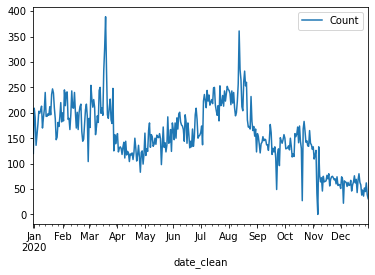

In [60]:
plot_day_count(df_submission['date_clean'])

We got some decline in post at the end of they year, I might have missed something in my scrapping

In [61]:
df_submission.subreddit_name_prefixed.unique()

array(['r/Leeds', 'r/Edinburgh', 'r/london', 'r/manchester', 'r/glasgow',
       'r/Liverpool', 'r/sheffield', 'r/Cardiff', 'r/Belfast'],
      dtype=object)

r/Leeds
r/Edinburgh
r/london
r/manchester
r/glasgow
r/Liverpool
r/sheffield
r/Cardiff
r/Belfast


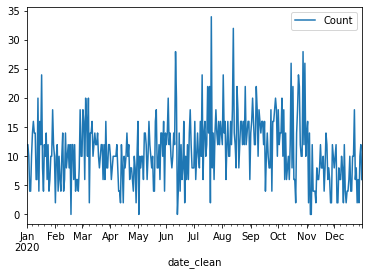

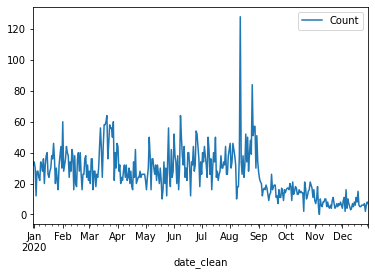

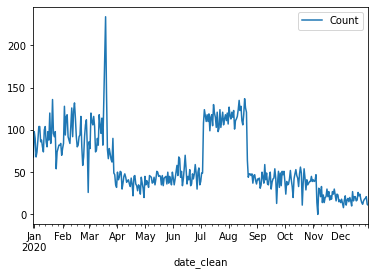

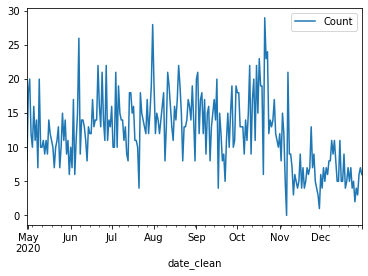

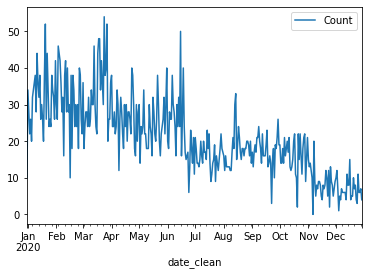

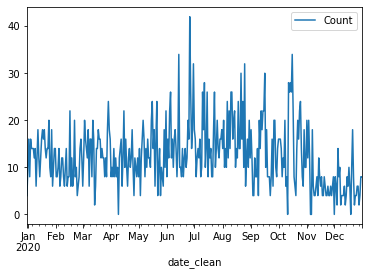

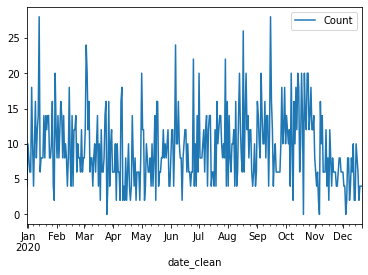

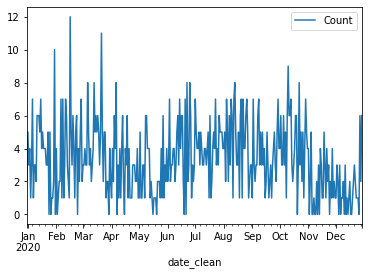

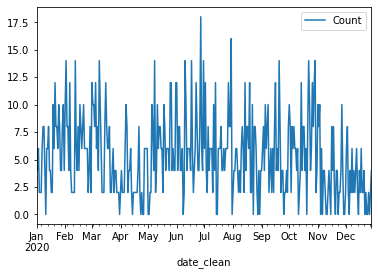

In [68]:
for city in df_submission.subreddit_name_prefixed.unique():
    print(city)
    plot_day_count(df_submission[df_submission.subreddit_name_prefixed == city]['date_clean'])

In [66]:
df_submission[df_submission.subreddit_name_prefixed == 'r/london']['date_clean']

0      2020-08-04T17:39:20Z
1      2020-08-04T17:41:38Z
2      2020-08-04T18:02:21Z
3      2020-08-04T18:15:10Z
4      2020-08-04T18:24:14Z
               ...         
495    2020-08-04T16:40:31Z
496    2020-08-04T17:01:04Z
497    2020-08-04T17:03:16Z
498    2020-08-04T17:04:47Z
499    2020-08-04T17:22:21Z
Name: date_clean, Length: 22279, dtype: object